In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [2]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-13 23:34:16.474126
Using this many files 4088


In [3]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'camps_stacked', 'abandons', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3215497967,
 3215097220,
 3215312675,
 3215162338,
 3215181105,
 3215377994,
 3215271631,
 3215289100,
 3215279863,
 3215253055,
 3215448302,
 3215416370,
 3215261563,
 3215294948,
 3215155134,
 3215350255,
 3215341221,
 3215306187,
 3215302636,
 3215316820,
 3215190109,
 3215355847,
 3215130854,
 3215259897,
 3215394671,
 3215152225,
 3215274711,
 3215366609,
 3215449992,
 3215376405,
 3215268540,
 3215420902,
 3215332931,
 3215327547,
 3215354992,
 3215254939,
 3215149372,
 3215370025,
 3215201012,
 3215272070,
 3215223639,
 3215422492,
 3215260456,
 3215354934,
 3215377592,
 3215445972,
 3215101148,
 3215174827,
 3215384305,
 3215188370,
 3215297782,
 3215493515,
 3215119808,
 3215360521,
 3215102154,
 3215271055,
 3215403667,
 3215217460,
 3215482564,
 3215466626,
 3215255292,
 3215095789,
 3215108689,
 3215330831,
 3215468550,
 3215446132,
 3215384555,
 3215470445,
 3215318005,
 3215238829,
 3215293087,
 3215391855,
 3215439074,
 3215401870,
 3215440922,
 3215092973,
 3215369622,

In [8]:
df['residual'].values.tolist()

[60.09383010864258,
 22.98058319091797,
 14.018461227416992,
 12.276541709899902,
 10.960655212402344,
 10.190336227416992,
 9.797115325927734,
 8.665862083435059,
 8.291083335876465,
 6.753566265106201,
 5.982767105102539,
 5.009283542633057,
 4.787799835205078,
 4.737585544586182,
 4.151325702667236,
 3.8586721420288086,
 3.7200565338134766,
 3.653451919555664,
 3.6120126247406006,
 3.55796217918396,
 3.5249321460723877,
 3.4550528526306152,
 3.4301578998565674,
 2.9261271953582764,
 2.8132457733154297,
 2.767648220062256,
 2.758488178253174,
 2.543581247329712,
 2.5158803462982178,
 2.4831578731536865,
 2.4762089252471924,
 2.392141342163086,
 2.38230299949646,
 2.3297765254974365,
 2.2398288249969482,
 2.229811429977417,
 2.1894421577453613,
 2.1700241565704346,
 2.150897741317749,
 2.0817346572875977,
 2.0602142810821533,
 2.044538974761963,
 2.038116693496704,
 2.0010886192321777,
 1.953024983406067,
 1.9425238370895386,
 1.919196367263794,
 1.8698474168777466,
 1.823149442672729

In [9]:
np.percentile(df['residual'], .9)

0.08401429408043623

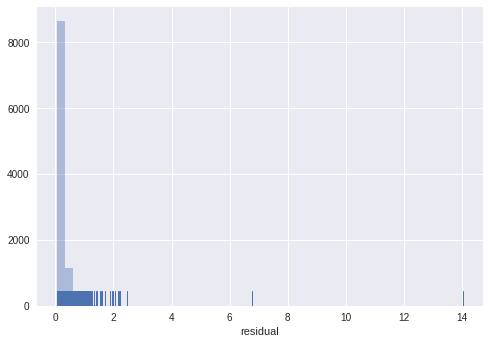

In [10]:
sns.distplot(df['residual'].sample(n=10000),  kde=False, rug=True)
plt.show()

In [11]:
len(df)

42798

In [12]:
plt.close()

In [13]:
residuals = df['residual'].values.tolist()

In [14]:
np.max(residuals) - np.min(residuals)

60.033355519175529

In [15]:
df['residual']

30570    60.093830
8855     22.980583
7254     14.018461
12561    12.276542
22835    10.960655
21943    10.190336
28061     9.797115
18164     8.665862
35826     8.291083
34817     6.753566
32145     5.982767
41438     5.009284
21721     4.787800
5187      4.737586
7110      4.151326
5437      3.858672
17215     3.720057
16919     3.653452
16894     3.612013
3078      3.557962
41542     3.524932
2383      3.455053
193       3.430158
6523      2.926127
20726     2.813246
6192      2.767648
27529     2.758488
16735     2.543581
4583      2.515880
38656     2.483158
           ...    
30972     0.069483
32988     0.069253
24956     0.069227
34036     0.069197
3581      0.069074
30044     0.069049
3973      0.068937
28703     0.068805
15472     0.068641
15284     0.068497
18310     0.068060
33262     0.067955
18884     0.067766
24449     0.067643
11612     0.067419
28751     0.066208
40856     0.065560
32313     0.065004
5068      0.064927
32986     0.064823
15091     0.064179
5125      0.

In [16]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

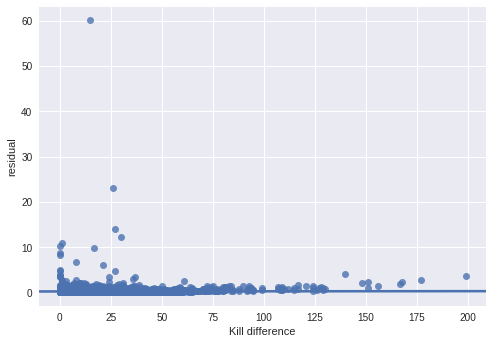

In [17]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

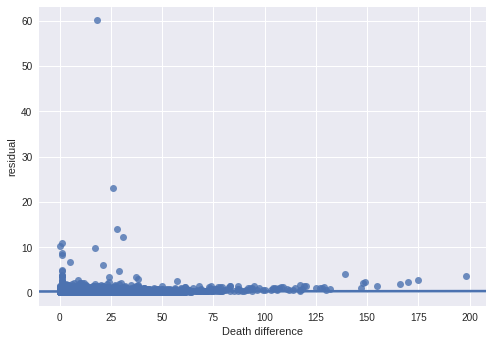

In [18]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

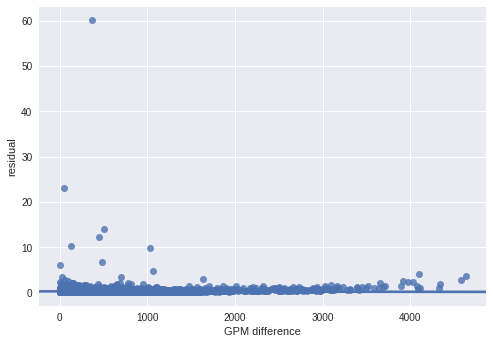

In [19]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

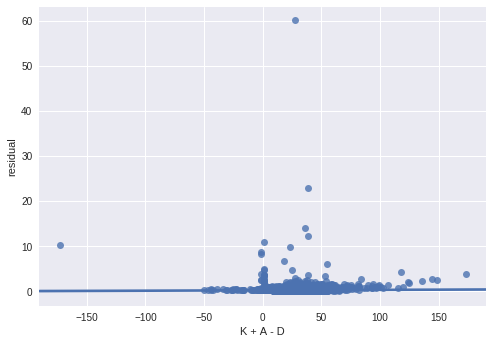

In [20]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

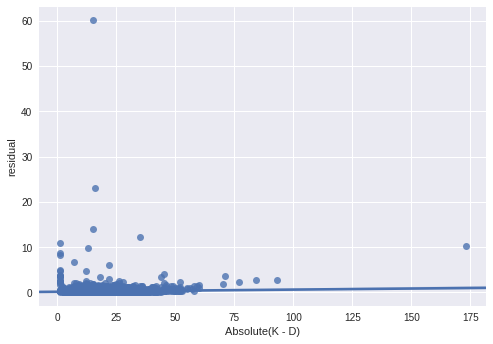

In [21]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

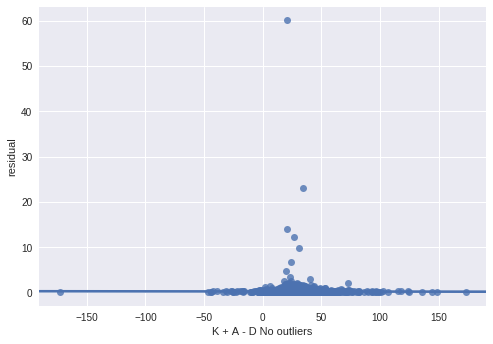

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

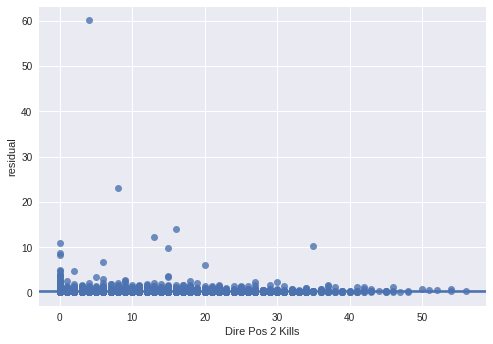

In [23]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

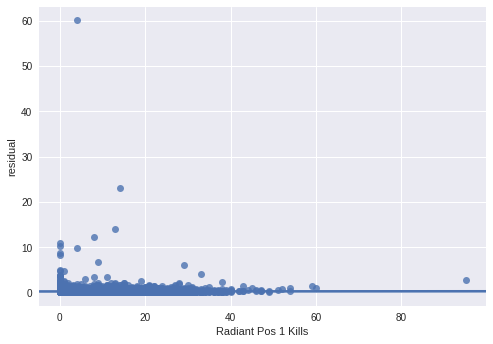

In [24]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

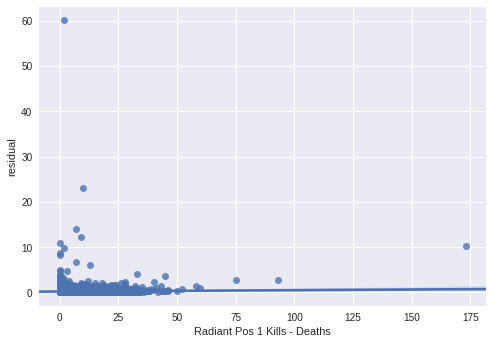

In [25]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

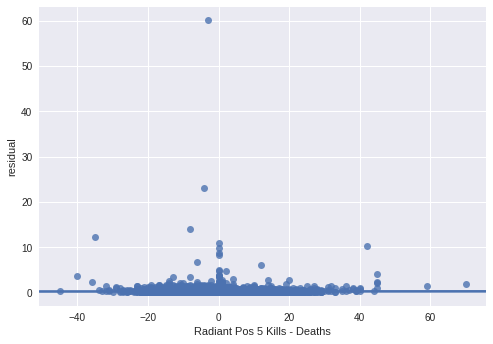

In [26]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

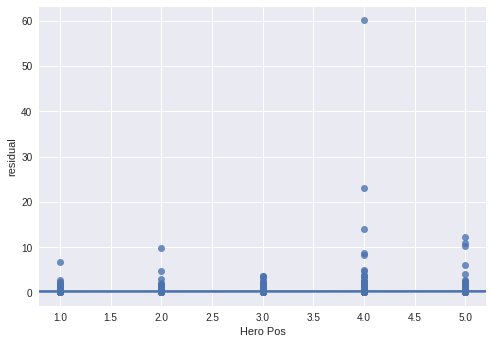

In [27]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

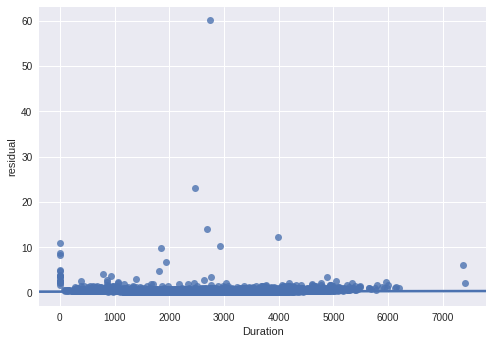

In [28]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [31]:
df[df['residual'] > 0.1]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
30570,3215497967,49,2,14,True,2748,43.0,0.0,4,141.0,...,0,0,0,0,0,0,0,0,0,60.093830
8855,3215097220,15,7,15,True,2470,23.0,0.0,7,108.0,...,0,0,0,0,0,0,0,0,0,22.980583
7254,3215312675,9,4,0,False,2687,0.0,0.0,10,9.0,...,0,0,0,0,0,0,0,0,0,14.018461
12561,3215162338,0,0,135,False,3981,18.0,21.0,27,70.0,...,0,0,0,0,0,0,0,0,0,12.276542
22835,3215181105,0,0,0,True,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,1,0,10.960655
21943,3215377994,0,0,72,False,2924,NaN,NaN,28,NaN,...,0,0,0,0,0,0,0,0,0,10.190336
28061,3215271631,7,1,3,False,1846,4.0,0.0,5,36.0,...,0,0,0,0,0,0,0,0,0,9.797115
18164,3215289100,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.665862
35826,3215279863,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.291083
34817,3215253055,5,0,182,True,1949,0.0,0.0,4,10.0,...,0,0,0,0,0,0,0,0,0,6.753566


In [30]:
df[df['residual'] < 0.08].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
40611,3215345247,0,0,130,True,2724,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,0.077793
10376,3215385097,0,0,142,True,2817,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,0.074403
6793,3215189135,0,0,77,True,2633,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.073280
13228,3215370398,0,0,13,True,2539,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.060731
1476,3215453195,0,0,226,True,2607,NaN,NaN,11,NaN,...,0,0,0,0,0,0,0,0,0,0.070520
2778,3215287528,0,0,103,True,2815,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,0.077429
18310,3215091914,0,0,120,False,2710,NaN,NaN,18,NaN,...,0,0,0,0,0,0,0,0,0,0.068060
9919,3215342354,0,0,230,True,2475,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.075910
24449,3215359693,0,0,68,True,2461,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,0.067643
4956,3215390401,0,0,175,True,2414,NaN,NaN,8,NaN,...,0,0,0,0,0,0,0,0,0,0.078218


In [ ]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [ ]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index
columns = list(df.columns)
columns.remove('match_id')
for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    df.columns[index]
    print index, columns[index], biggestAnom[i, index], theirOutput[i, index]

In [ ]:
set(theirOutput[:, 9])

In [ ]:
set(biggestAnom[:, 9])

In [ ]:
bias_1 = pd.read_csv('data/bias1.csv')

In [ ]:
bias_1

In [ ]:
weights_1 = pd.read_csv('data/weights1.csv')
weights_1

In [ ]:
df.columns